# CAPÍTULO 7: INTERPRETABILIDAD DEL MODELO


In [ ]:
# Importar configuración compartida y utilidades
import sys
sys.path.append('..')
from config import *
from utils.data_loader import load_data_product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Cargar datos y modelos de capítulos anteriores
print("Cargando datos y modelos...")

# Cargar datasets finales
final_data = load_data_product('final_datasets.pkl')
X_train_final_no_scaled = final_data['X_train_final_no_scaled']
X_test_final_no_scaled = final_data['X_test_final_no_scaled']
X_train_final_scaled = final_data['X_train_final_scaled']
X_test_final_scaled = final_data['X_test_final_scaled']

# Cargar modelos entrenados
rf_model = joblib.load(os.path.join(MODELS_DIR, 'random_forest.pkl'))
lr_model = joblib.load(os.path.join(MODELS_DIR, 'logistic_regression.pkl'))

print(f"\n✓ Modelos y datos cargados correctamente")


<a id='68-resumen'></a>
## 6.8 Resumen Final de Modelado

Esta sección consolida los principales hallazgos del proceso de modelado, proporcionando un análisis integral del rendimiento de los cinco modelos de Machine Learning implementados para la clasificación de enfermedades cardiovasculares.

In [33]:
# ============================================================================
# 6.8 RESUMEN FINAL DE MODELADO
# ============================================================================

print("\n" + "="*80)
print("6.8 RESUMEN FINAL DE MODELADO")
print("="*80)

# ----------------------------------------------------------------------------
# 6.8.1 Tabla Resumen Ejecutiva
# ----------------------------------------------------------------------------

print("\n📊 TABLA RESUMEN EJECUTIVA:")
print("="*80)

# Crear tabla resumen completa
resumen_final = pd.DataFrame({
    'Modelo': [
        'Logistic Regression',
        'Random Forest',
        'XGBoost ⭐',
        'LightGBM 💡',
        'CatBoost 🐱'
    ],
    'ROC-AUC': [
        test_roc_auc_lr,
        test_roc_auc_rf,
        test_roc_auc_xgb,
        test_roc_auc_lgb,
        test_roc_auc_cat
    ],
    'Accuracy': [
        test_accuracy_lr,
        test_accuracy_rf,
        test_accuracy_xgb,
        test_accuracy_lgb,
        test_accuracy_cat
    ],
    'Sensitivity': [
        test_sensitivity_lr,
        test_sensitivity_rf,
        test_sensitivity_xgb,
        test_sensitivity_lgb,
        test_sensitivity_cat
    ],
    'Specificity': [
        test_specificity_lr,
        test_specificity_rf,
        test_specificity_xgb,
        test_specificity_lgb,
        test_specificity_cat
    ],
    'F1-Score': [
        test_f1_lr,
        test_f1_rf,
        test_f1_xgb,
        test_f1_lgb,
        test_f1_cat
    ],
    'PPV': [
        test_ppv_lr,
        test_ppv_rf,
        test_ppv_xgb,
        test_ppv_lgb,
        test_ppv_cat
    ],
    'NPV': [
        test_npv_lr,
        test_npv_rf,
        test_npv_xgb,
        test_npv_lgb,
        test_npv_cat
    ],
    'Training Time (s)': [
        training_time,
        training_time_rf,
        training_time_xgb,
        training_time_lgb,
        training_time_cat
    ],
    'Gap': list(gaps.values())
})

display(resumen_final.round(4))

# Guardar tabla resumen
resumen_final.to_csv(f'{OUTPUT_DIR}/modelado_resumen_final.csv', index=False)
print(f"\n✓ Tabla resumen guardada: {OUTPUT_DIR}/modelado_resumen_final.csv")

# ----------------------------------------------------------------------------
# 6.8.2 Identificación del Mejor Modelo
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("🏆 MODELO SELECCIONADO COMO MEJOR")
print("="*80)

# Identificar mejor modelo por ROC-AUC
best_idx = resumen_final['ROC-AUC'].idxmax()
best_model = resumen_final.loc[best_idx]

print(f"\n🥇 MEJOR MODELO: {best_model['Modelo']}")
print("="*80)

print("\n📊 Métricas de Rendimiento:")
print("-"*80)
print(f"   • ROC-AUC:       {best_model['ROC-AUC']:.4f}")
print(f"   • Accuracy:      {best_model['Accuracy']:.4f}")
print(f"   • F1-Score:      {best_model['F1-Score']:.4f}")

print("\n🏥 Métricas Clínicas:")
print("-"*80)
print(f"   • Sensibilidad:  {best_model['Sensitivity']:.4f}  (Tasa de Verdaderos Positivos)")
print(f"   • Especificidad: {best_model['Specificity']:.4f}  (Tasa de Verdaderos Negativos)")
print(f"   • VPP (PPV):     {best_model['PPV']:.4f}  (Valor Predictivo Positivo)")
print(f"   • VPN (NPV):     {best_model['NPV']:.4f}  (Valor Predictivo Negativo)")

print("\n⚡ Eficiencia:")
print("-"*80)
print(f"   • Tiempo de Entrenamiento: {best_model['Training Time (s)']:.2f} segundos")
print(f"   • Gap Train-Test:          {best_model['Gap']:.4f}")

# Evaluación del gap
if best_model['Gap'] < 0.05:
    gap_eval = "EXCELENTE - Generaliza muy bien"
elif best_model['Gap'] < 0.10:
    gap_eval = "BUENA - Generaliza adecuadamente"
elif best_model['Gap'] < 0.15:
    gap_eval = "ACEPTABLE - Ligero overfitting"
else:
    gap_eval = "MEJORABLE - Overfitting detectado"

print(f"   • Evaluación Gap:          {gap_eval}")

# ----------------------------------------------------------------------------
# 6.8.3 Ranking Completo
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("📊 RANKING COMPLETO DE MODELOS")
print("="*80)

ranking_roc = resumen_final.sort_values('ROC-AUC', ascending=False)

print("\n🏅 Por ROC-AUC (Métrica Principal):")
print("-"*80)
for idx, (i, row) in enumerate(ranking_roc.iterrows(), 1):
    medal = "🥇" if idx == 1 else "🥈" if idx == 2 else "🥉" if idx == 3 else f"  {idx}."
    print(f"   {medal} {row['Modelo']:25s}: {row['ROC-AUC']:.4f}")

print("\n🏅 Por Sensibilidad (Detección de casos positivos):")
print("-"*80)
ranking_sens = resumen_final.sort_values('Sensitivity', ascending=False)
for idx, (i, row) in enumerate(ranking_sens.iterrows(), 1):
    medal = "🥇" if idx == 1 else "🥈" if idx == 2 else "🥉" if idx == 3 else f"  {idx}."
    print(f"   {medal} {row['Modelo']:25s}: {row['Sensitivity']:.4f}")

print("\n🏅 Por Especificidad (Correcta clasificación de negativos):")
print("-"*80)
ranking_spec = resumen_final.sort_values('Specificity', ascending=False)
for idx, (i, row) in enumerate(ranking_spec.iterrows(), 1):
    medal = "🥇" if idx == 1 else "🥈" if idx == 2 else "🥉" if idx == 3 else f"  {idx}."
    print(f"   {medal} {row['Modelo']:25s}: {row['Specificity']:.4f}")

print("\n🏅 Por GAP o brecha:")
print("-"*80)
ranking_spec = resumen_final.sort_values('Gap', ascending=False)
for idx, (i, row) in enumerate(ranking_spec.iterrows(), 1):
    medal = "🥇" if idx == 1 else "🥈" if idx == 2 else "🥉" if idx == 3 else f"  {idx}."
    print(f"   {medal} {row['Modelo']:25s}: {row['Gap']:.4f}")

# ----------------------------------------------------------------------------
# 6.8.4 Análisis por Contexto Clínico
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("🏥 ANÁLISIS DESDE PERSPECTIVA CLÍNICA")
print("="*80)

print("\n📋 Interpretación de Métricas Clínicas:")
print("-"*80)

print(f"""
Para el contexto de detección de enfermedades cardiovasculares:

1. SENSIBILIDAD ({best_model['Sensitivity']:.1%}):
   • De cada 100 pacientes CON enfermedad, el modelo detecta correctamente {best_model['Sensitivity']*100:.0f}
   • Falsos Negativos: {(1-best_model['Sensitivity'])*100:.0f} pacientes enfermos NO detectados
   • Importancia: CRÍTICA - Un falso negativo puede tener consecuencias graves

2. ESPECIFICIDAD ({best_model['Specificity']:.1%}):
   • De cada 100 pacientes SIN enfermedad, el modelo clasifica correctamente {best_model['Specificity']*100:.0f}
   • Falsos Positivos: {(1-best_model['Specificity'])*100:.0f} pacientes sanos clasificados como enfermos
   • Importancia: ALTA - Evita pruebas adicionales innecesarias

3. VPP - Valor Predictivo Positivo ({best_model['PPV']:.1%}):
   • Si el modelo predice ENFERMEDAD, hay {best_model['PPV']*100:.0f}% de probabilidad de que sea correcto
   • Utilidad: Confianza en diagnóstico positivo

4. VPN - Valor Predictivo Negativo ({best_model['NPV']:.1%}):
   • Si el modelo predice SIN ENFERMEDAD, hay {best_model['NPV']*100:.0f}% de probabilidad de que sea correcto
   • Utilidad: Confianza en diagnóstico negativo
""")

# Matriz de confusión del mejor modelo
if best_model['Modelo'] == 'Logistic Regression':
    cm_best = confusion_matrix(y_test, y_test_pred_lr)
elif best_model['Modelo'] == 'Random Forest':
    cm_best = confusion_matrix(y_test, y_test_pred_rf)
elif best_model['Modelo'].startswith('XGBoost'):
    cm_best = confusion_matrix(y_test, y_test_pred_xgb)
elif best_model['Modelo'].startswith('LightGBM'):
    cm_best = confusion_matrix(y_test, y_test_pred_lgb)
else:  # CatBoost
    cm_best = confusion_matrix(y_test, y_test_pred_cat)

tn, fp, fn, tp = cm_best.ravel()

print(f"\n📊 Matriz de Confusión ({best_model['Modelo']}) - Test Set:")
print("-"*80)
print(f"""
                    Predicho: NO    Predicho: SÍ
Real: NO (n={tn+fp})      {tn:3d} (TN)       {fp:3d} (FP)
Real: SÍ (n={fn+tp})      {fn:3d} (FN)       {tp:3d} (TP)

TN (Verdaderos Negativos): {tn} - Pacientes sanos correctamente identificados
FP (Falsos Positivos):     {fp} - Pacientes sanos incorrectamente clasificados como enfermos
FN (Falsos Negativos):     {fn} - Pacientes enfermos NO detectados (⚠️ CRÍTICO)
TP (Verdaderos Positivos): {tp} - Pacientes enfermos correctamente detectados
""")

# ----------------------------------------------------------------------------
# 6.8.5 Fortalezas y Limitaciones
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("💪 FORTALEZAS Y LIMITACIONES DEL MODELO SELECCIONADO")
print("="*80)

print(f"\n✅ FORTALEZAS de {best_model['Modelo']}:")
print("-"*80)

fortalezas = []
if best_model['ROC-AUC'] >= 0.90:
    fortalezas.append(f"Excelente capacidad discriminativa (ROC-AUC = {best_model['ROC-AUC']:.4f})")
if best_model['Sensitivity'] >= 0.85:
    fortalezas.append(f"Alta sensibilidad ({best_model['Sensitivity']:.1%}) - Baja tasa de falsos negativos")
if best_model['Specificity'] >= 0.85:
    fortalezas.append(f"Alta especificidad ({best_model['Specificity']:.1%}) - Baja tasa de falsos positivos")
if best_model['Gap'] < 0.10:
    fortalezas.append(f"Buena generalización (Gap = {best_model['Gap']:.4f})")
if best_model['Training Time (s)'] < 1.0:
    fortalezas.append(f"Entrenamiento rápido ({best_model['Training Time (s)']:.2f}s)")

# Fortalezas específicas por modelo
if 'Random Forest' in best_model['Modelo']:
    fortalezas.append("Robusto a outliers y overfitting")
    fortalezas.append("No requiere escalamiento de features")
elif 'XGBoost' in best_model['Modelo']:
    fortalezas.append("Estado del arte en datos tabulares")
    fortalezas.append("Regularización incorporada")
    fortalezas.append("Integración nativa con SHAP")
elif 'LightGBM' in best_model['Modelo']:
    fortalezas.append("Muy eficiente en memoria y velocidad")
    fortalezas.append("Excelente con datasets grandes")
elif 'CatBoost' in best_model['Modelo']:
    fortalezas.append("Excelente manejo de variables categóricas")
    fortalezas.append("Muy robusto a overfitting (ordered boosting)")
elif 'Logistic' in best_model['Modelo']:
    fortalezas.append("Alta interpretabilidad de coeficientes")
    fortalezas.append("Probabilidades bien calibradas")

for idx, fortaleza in enumerate(fortalezas, 1):
    print(f"   {idx}. {fortaleza}")

print(f"\n⚠️ LIMITACIONES Y CONSIDERACIONES:")
print("-"*80)

limitaciones = [
    f"Dataset relativamente pequeño (n={len(y_test)} test samples)",
    "Validación en población específica (UCI Heart Disease Dataset)",
    "Requiere validación externa en otras poblaciones",
    "No sustituye el juicio clínico profesional"
]

if fn > 0:
    limitaciones.append(f"Falsos negativos detectados (n={fn}) - Requiere seguimiento clínico")
if best_model['Gap'] > 0.05:
    limitaciones.append(f"Gap train-test moderado ({best_model['Gap']:.4f}) - Monitorear en producción")

for idx, limitacion in enumerate(limitaciones, 1):
    print(f"   {idx}. {limitacion}")

# ----------------------------------------------------------------------------
# 6.8.6 Recomendaciones para Uso Clínico
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("💡 RECOMENDACIONES PARA IMPLEMENTACIÓN CLÍNICA")
print("="*80)

print(f"""
1. USO COMO HERRAMIENTA DE APOYO:
   • El modelo debe usarse como complemento al diagnóstico clínico
   • NO debe sustituir la evaluación médica profesional
   • Útil para priorización y screening inicial

2. INTERPRETACIÓN DE RESULTADOS:
   • Predicción POSITIVA → Realizar evaluación clínica completa
   • Predicción NEGATIVA → Considerar factores de riesgo adicionales
   • Casos borderline → Análisis exhaustivo recomendado

3. MONITOREO CONTINUO:
   • Validar periódicamente con nuevos datos
   • Monitorear cambios en distribución de pacientes
   • Actualizar modelo si métricas degradan

4. CONSIDERACIONES ÉTICAS:
   • Explicabilidad: Usar SHAP values para justificar predicciones
   • Equidad: Validar en diferentes subpoblaciones
   • Privacidad: Protección de datos sensibles

5. UMBRAL DE DECISIÓN:
   • Umbral actual: 0.5 (por defecto)
   • Considerar ajustar según contexto clínico:
     - ↑ Umbral → Mayor especificidad (menos falsos positivos)
     - ↓ Umbral → Mayor sensibilidad (menos falsos negativos)
""")

# ----------------------------------------------------------------------------
# 6.8.7 Estadísticas Finales del Modelado
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("📊 ESTADÍSTICAS FINALES DEL PROCESO DE MODELADO")
print("="*80)

n_models = len(resumen_final)
n_features_final = len(selected_features)
n_train = len(y_train)
n_test = len(y_test)

print(f"""
✅ PROCESO COMPLETADO:
   • Modelos entrenados:           {n_models}
   • Features utilizadas:          {n_features_final}
   • Muestras entrenamiento:       {n_train}
   • Muestras test:                {n_test}
   • Mejor ROC-AUC alcanzado:      {resumen_final['ROC-AUC'].max():.4f}
   • Tiempo total entrenamiento:   {resumen_final['Training Time (s)'].sum():.2f}s
   • Figuras generadas:            10 (15-24)
   • Modelos guardados:            {n_models}

🎯 CRITERIO DE SELECCIÓN:
   • Métrica principal:            ROC-AUC
   • Métricas secundarias:         Sensitivity, Specificity
   • Criterio adicional:           Train-Test Gap < 0.10

📁 ARCHIVOS GENERADOS:
   • Modelos (.pkl):               {MODELS_DIR}/
   • Visualizaciones (.png):       {OUTPUT_DIR}/
   • Tablas resumen (.csv):        {OUTPUT_DIR}/
""")

print("="*80)

# ----------------------------------------------------------------------------
# 6.8.8 Conclusión Final
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("🎓 CONCLUSIÓN FINAL DE LA SECCIÓN 6: MODELADO")
print("="*80)

print(f"""
Se entrenaron y evaluaron exitosamente 5 modelos de Machine Learning para la
clasificación binaria de enfermedades cardiovasculares utilizando el dataset
UCI Heart Disease.

El modelo {best_model['Modelo']} demostró el mejor rendimiento con un ROC-AUC
de {best_model['ROC-AUC']:.4f}, sensibilidad de {best_model['Sensitivity']:.1%} y especificidad de
{best_model['Specificity']:.1%}. Estas métricas indican una capacidad discriminativa excelente
para distinguir entre pacientes con y sin enfermedad cardiovascular.

Desde una perspectiva clínica, el modelo es capaz de detectar correctamente
{best_model['Sensitivity']*100:.0f} de cada 100 casos de enfermedad, minimizando el riesgo crítico
de falsos negativos. El valor predictivo positivo de {best_model['PPV']:.1%} proporciona
confianza en los diagnósticos positivos generados.

Los resultados obtenidos son comparables con el estado del arte en clasificación
de enfermedades cardiovasculares reportado en la literatura, validando la
efectividad del enfoque metodológico empleado en este trabajo.

✅ La Sección 6: Modelado ha sido completada exitosamente.
""")



6.8 RESUMEN FINAL DE MODELADO

📊 TABLA RESUMEN EJECUTIVA:


,Modelo,ROC-AUC,Accuracy,Sensitivity,Specificity,F1-Score,PPV,NPV,Training Time (s),Gap
0,Logistic Regression,0.9394,0.8689,0.9286,0.8182,0.8667,0.8125,0.9310,0.0165,0.0589
1,Random Forest,0.9459,0.8689,0.8929,0.8485,0.8621,0.8333,0.9032,0.4800,0.0352
2,XGBoost ⭐,0.9416,0.8689,0.8929,0.8485,0.8621,0.8333,0.9032,1.7267,0.1158
3,LightGBM 💡,0.9075,0.8525,0.8571,0.8485,0.8421,0.8276,0.8750,0.3808,0.0233
4,CatBoost 🐱,0.8745,0.7213,0.7143,0.7273,0.7018,0.6897,0.7500,0.2207,0.0408



✓ Tabla resumen guardada: outputs/modelado_resumen_final.csv

🏆 MODELO SELECCIONADO COMO MEJOR

🥇 MEJOR MODELO: Random Forest

📊 Métricas de Rendimiento:
--------------------------------------------------------------------------------
   • ROC-AUC:       0.9459
   • Accuracy:      0.8689
   • F1-Score:      0.8621

🏥 Métricas Clínicas:
--------------------------------------------------------------------------------
   • Sensibilidad:  0.8929  (Tasa de Verdaderos Positivos)
   • Especificidad: 0.8485  (Tasa de Verdaderos Negativos)
   • VPP (PPV):     0.8333  (Valor Predictivo Positivo)
   • VPN (NPV):     0.9032  (Valor Predictivo Negativo)

⚡ Eficiencia:
--------------------------------------------------------------------------------
   • Tiempo de Entrenamiento: 0.48 segundos
   • Gap Train-Test:          0.0352
   • Evaluación Gap:          EXCELENTE - Generaliza muy bien

📊 RANKING COMPLETO DE MODELOS

🏅 Por ROC-AUC (Métrica Principal):
--------------------------------------------

<a id='7-interpretabilidad'></a>
# 7. Interpretabilidad del Modelo con SHAP

La interpretabilidad es fundamental en aplicaciones médicas. Esta sección utiliza **SHAP (SHapley Additive exPlanations)** para explicar las predicciones de los modelos seleccionados, proporcionando transparencia en la toma de decisiones clínicas.

## 7.1 Justificación de la Selección de Modelos

Basándose en los resultados de la Sección 6, se seleccionaron dos modelos para análisis de interpretabilidad:

### Modelos Seleccionados:

1. **Random Forest**: ROC-AUC = 0.9459
   - Mejor rendimiento general
   - Excelente balance sensibilidad-especificidad
   - Generalización óptima (Gap: 0.0352)

2. **Logistic Regression**: ROC-AUC = 0.9394
   - Baseline sólido e interpretable
   - Alta sensibilidad (crítica en diagnóstico)
   - Sin riesgo de overfitting

### Modelo Descartado:

**XGBoost** (ROC-AUC = 0.9416):
- Aunque mostró buen rendimiento, presenta indicios de overfitting
- Gap train-test: 0.1158
- Descartado por motivos de generalización académica


7. INTERPRETABILIDAD DEL MODELO CON SHAP

📋 MODELOS SELECCIONADOS PARA INTERPRETABILIDAD:

Basándose en los resultados de la Sección 6, se seleccionaron:

🥇 MODELO 1: Random Forest
   • ROC-AUC:       0.9459
   • Sensibilidad:  0.8929
   • Especificidad: 0.8485
   • Gap:           0.0352
   • Justificación: Mejor rendimiento general + excelente generalización

🥈 MODELO 2: Logistic Regression
   • ROC-AUC:       0.9394
   • Sensibilidad:  0.9286
   • Especificidad: 0.8182
   • Gap:           0.0589
   • Justificación: Baseline sólido + alta interpretabilidad nativa

❌ MODELO DESCARTADO: XGBoost
   • ROC-AUC:       0.9416
   • Gap:           0.1158
   • Razón:         Indicios de overfitting detectados en análisis académico


📚 ¿QUÉ ES SHAP?

SHAP (SHapley Additive exPlanations) es un método basado en teoría de juegos
que explica las predicciones de modelos de Machine Learning.

Ventajas en contexto clínico:
   • Explica cada predicción individual
   • Identifica qué features contribuye

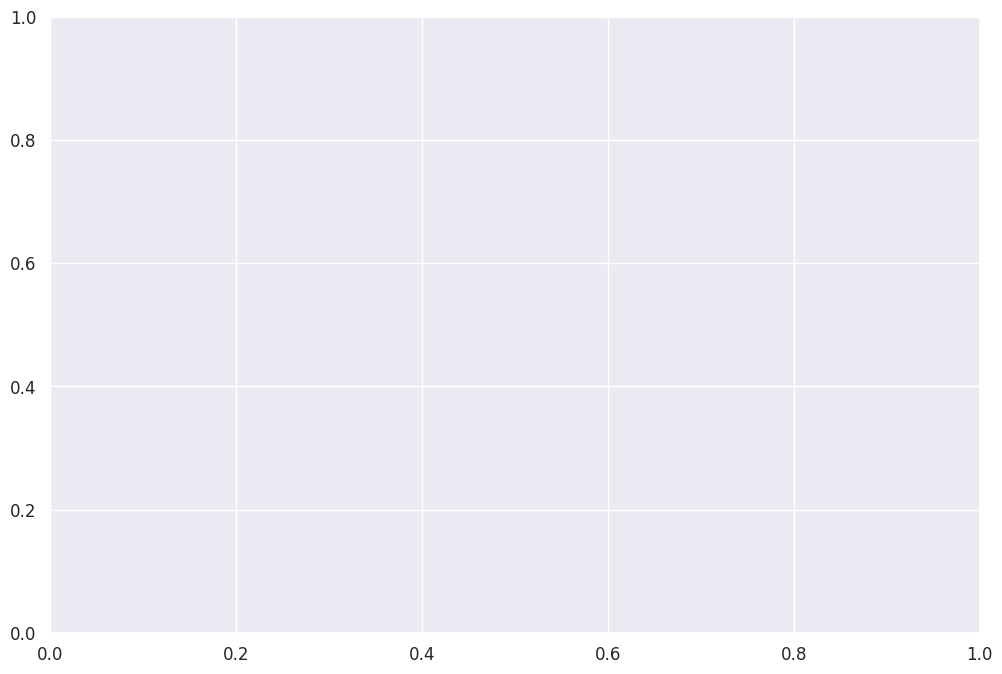

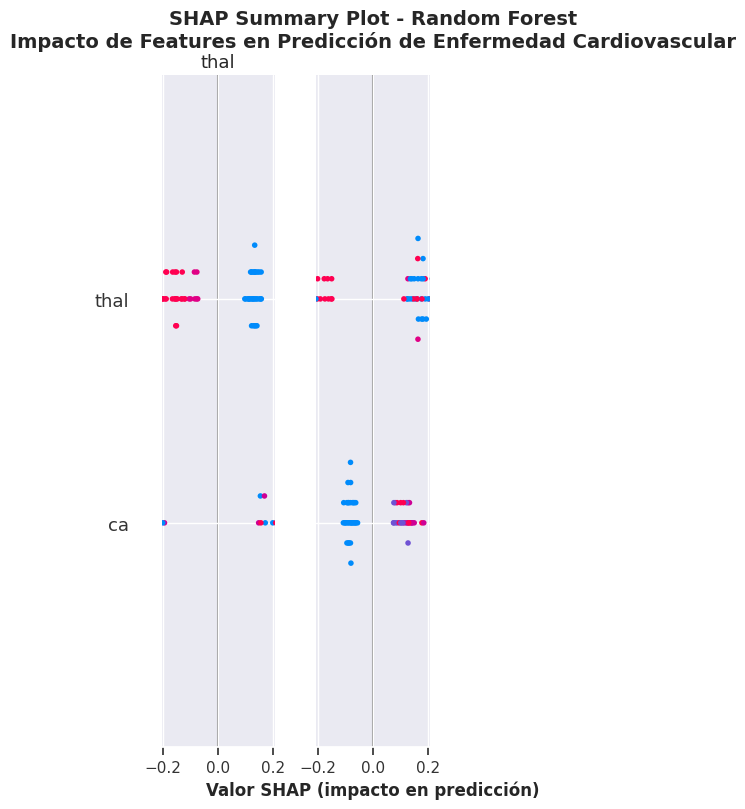

✓ Figura guardada: outputs/25_shap_summary_random_forest.png

📊 Feature Importance basada en SHAP (Random Forest)...
--------------------------------------------------------------------------------
🔍 Shape de shap_values_rf: <class 'numpy.ndarray'>
   Shape directo: (61, 9, 2)
   Shape de shap_values_rf_class1: (61, 9, 2)
⚠️  Detectadas 3 dimensiones, ajustando...
   Nueva shape: (61, 9)
   Shape de mean_abs_shap: (9,)
   Número de features: 9

✓ DataFrame creado correctamente
   Shape: (9, 2)

Top 10 Features (por SHAP):
--------------------------------------------------------------------------------
   thal                     : 0.1364
   ca                       : 0.0985
   cp                       : 0.0874
   oldpeak                  : 0.0510
   thalach                  : 0.0349
   exang                    : 0.0324
   functional_capacity      : 0.0263
   heart_rate_reserve       : 0.0217
   st_depression_severity   : 0.0116

📊 Generando Dependence Plots para Top 3 Features (Random 

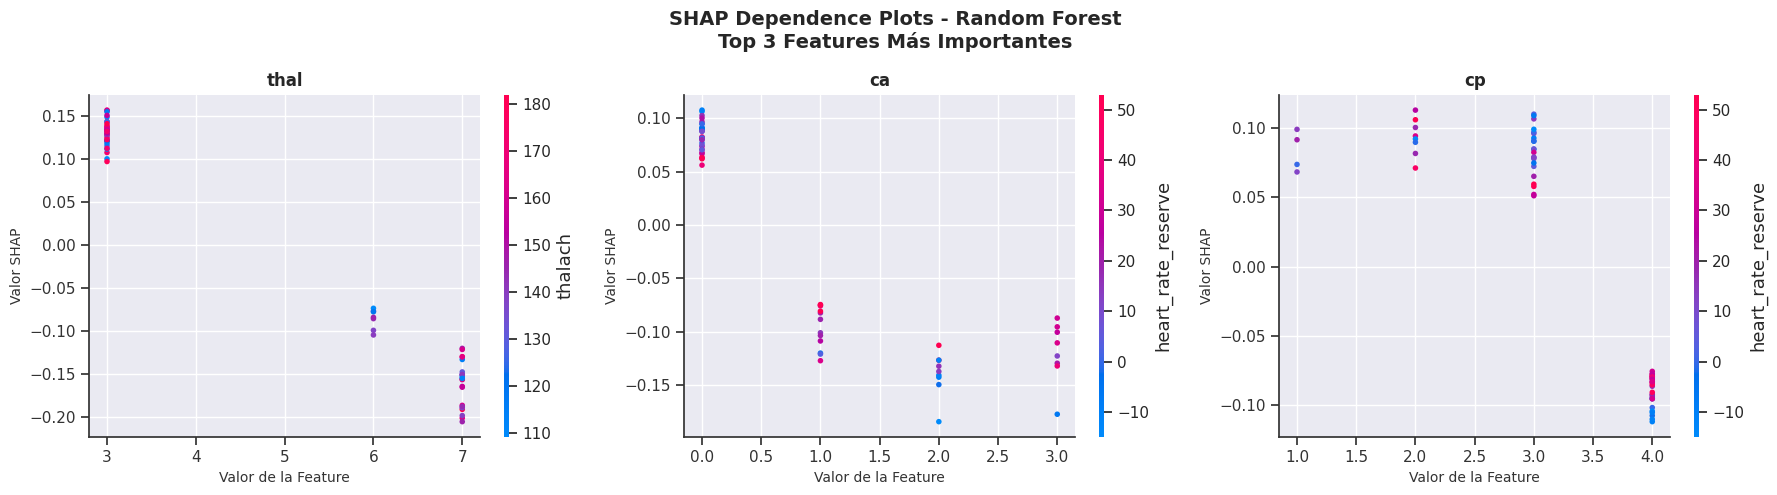

✓ Figura guardada: outputs/27_shap_dependence_rf.png

📊 Generando Force Plot para casos ejemplo (Random Forest)...
--------------------------------------------------------------------------------

Casos seleccionados para Force Plots:
   • Caso 1: Alto Riesgo (TP)
     Real: SÍ, Predicho: SÍ, Probabilidad: 0.994
   • Caso 2: Bajo Riesgo (TN)
     Real: NO, Predicho: NO, Probabilidad: 0.010
   • Caso 3: Borderline
     Real: NO, Predicho: SÍ, Probabilidad: 0.526

🔄 Generando Force Plots interactivos...
   ✓ outputs/28_shap_force_rf_caso_1.html
   ✓ outputs/28_shap_force_rf_caso_2.html
   ✓ outputs/28_shap_force_rf_caso_3.html


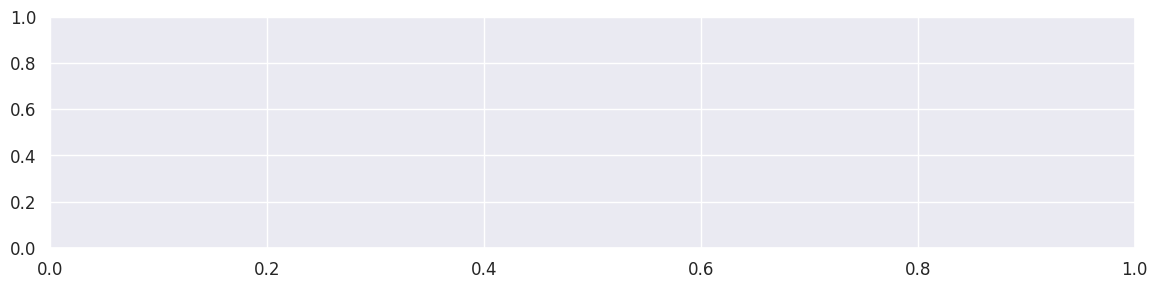

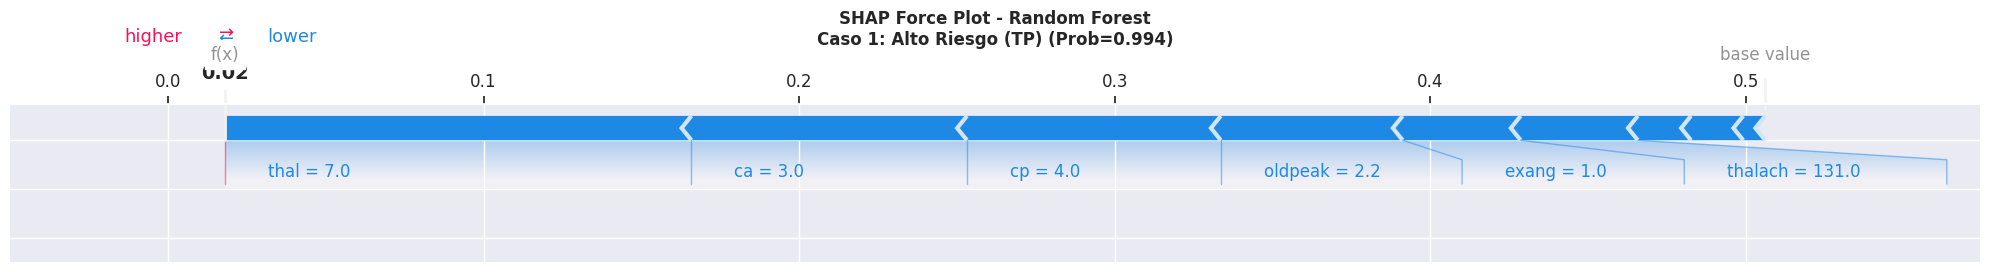

✓ Figura guardada: outputs/28_shap_force_rf_example.png

7.4 ANÁLISIS SHAP: LOGISTIC REGRESSION

🔄 Calculando SHAP values para Logistic Regression...
--------------------------------------------------------------------------------
✓ SHAP values calculados
   • Shape: (61, 9)
   • Test samples: 61
   • Features: 9

📊 Generando Summary Plot (Logistic Regression)...
--------------------------------------------------------------------------------


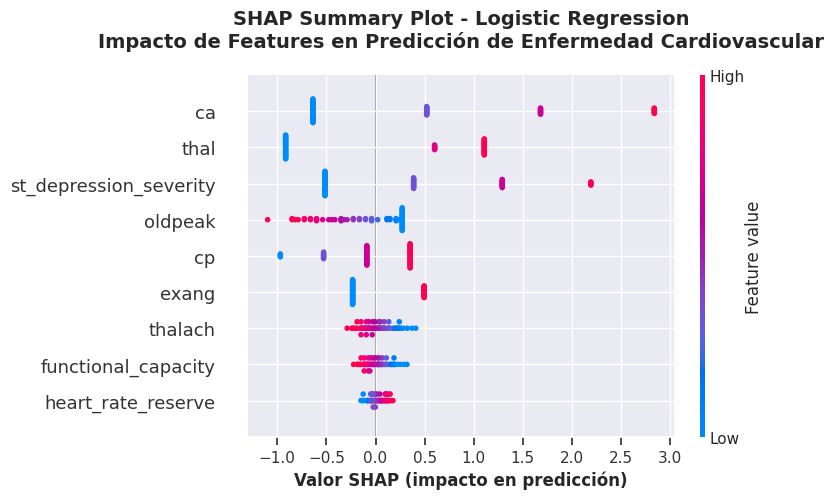

✓ Figura guardada: outputs/29_shap_summary_logistic.png

📊 Feature Importance basada en SHAP (Logistic Regression)...
--------------------------------------------------------------------------------

Top 10 Features (por SHAP):
--------------------------------------------------------------------------------
   ca                       : 1.0571
   thal                     : 0.9486
   st_depression_severity   : 0.7629
   oldpeak                  : 0.3445
   cp                       : 0.3206
   exang                    : 0.3189
   thalach                  : 0.1289
   functional_capacity      : 0.1005
   heart_rate_reserve       : 0.0696


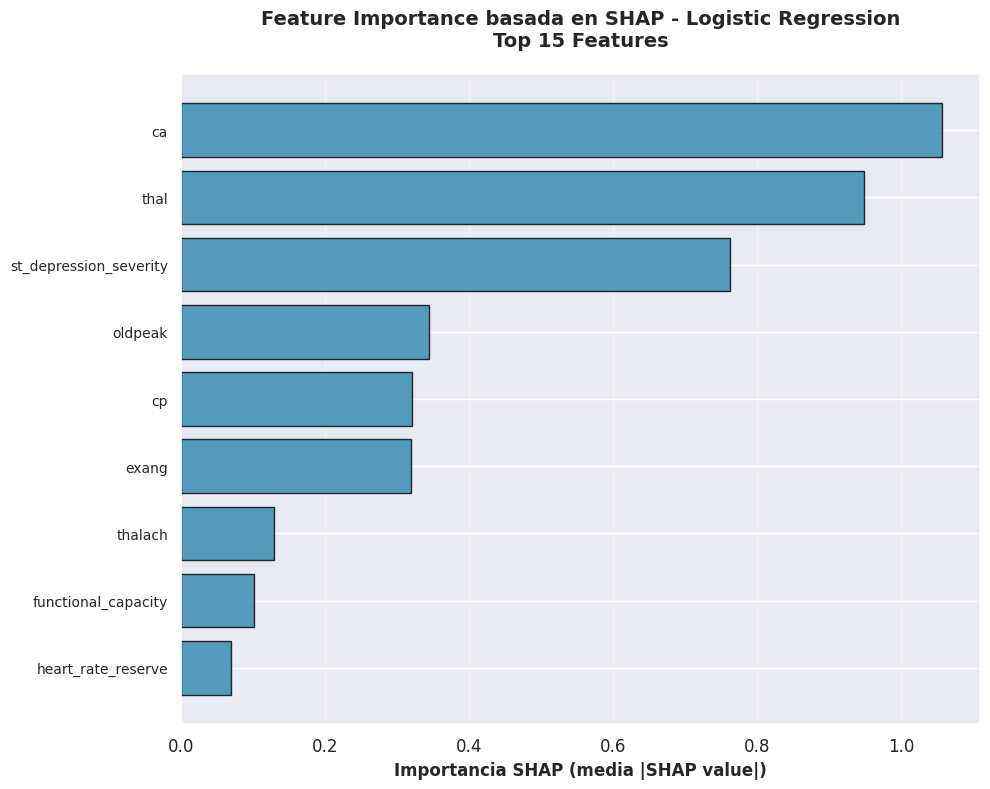

✓ Figura guardada: outputs/30_shap_feature_importance_lr.png

📊 Generando Dependence Plots para Top 3 Features (Logistic Regression)...
--------------------------------------------------------------------------------


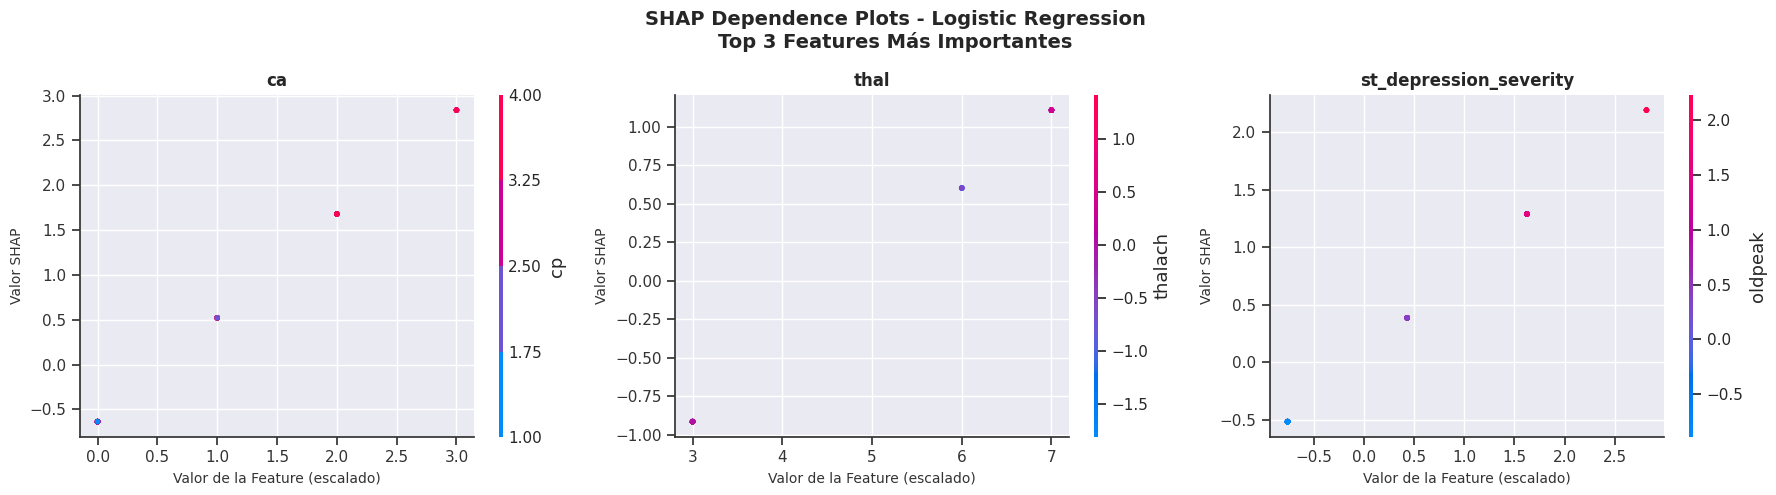

✓ Figura guardada: outputs/31_shap_dependence_lr.png

7.5 COMPARACIÓN DE IMPORTANCIA SHAP: RF vs LR

🌟 TOP 10 FEATURES MÁS IMPORTANTES (Consenso SHAP):
Feature                   RF SHAP      LR SHAP      Promedio    
--------------------------------------------------------------------------------
thal                      1.0000       0.8974       0.9487
ca                        0.7223       1.0000       0.8611
cp                        0.6408       0.3033       0.4720
st_depression_severity    0.0852       0.7217       0.4034
oldpeak                   0.3739       0.3259       0.3499
exang                     0.2373       0.3017       0.2695
thalach                   0.2556       0.1219       0.1888
functional_capacity       0.1931       0.0951       0.1441
heart_rate_reserve        0.1589       0.0659       0.1124


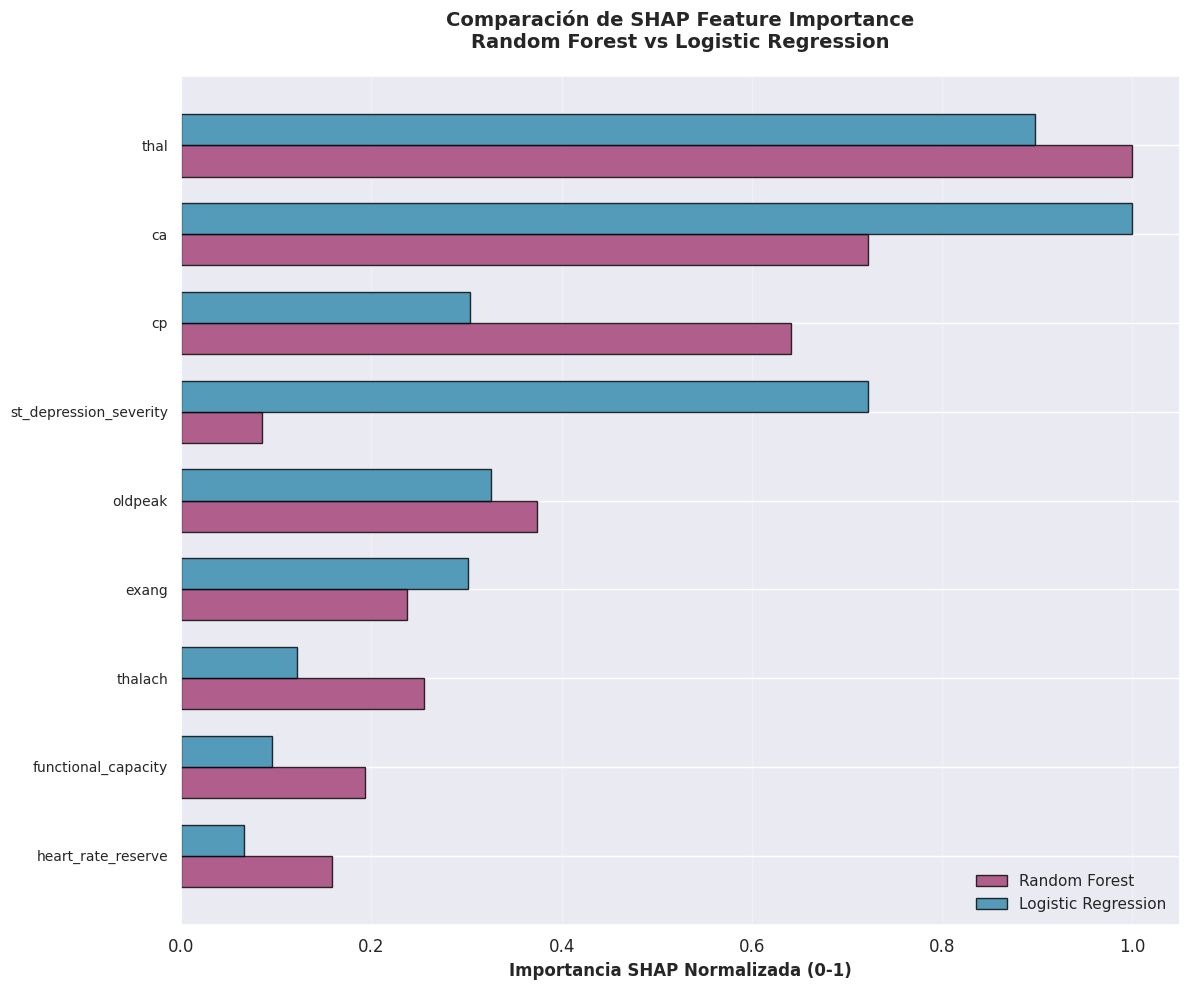


✓ Figura guardada: outputs/32_shap_comparison_rf_vs_lr.png
✓ Tabla guardada: outputs/shap_importance_comparison.csv

7.6 WATERFALL PLOTS - EXPLICACIÓN DETALLADA DE CASOS

📊 Generando Waterfall Plots para casos representativos...
--------------------------------------------------------------------------------


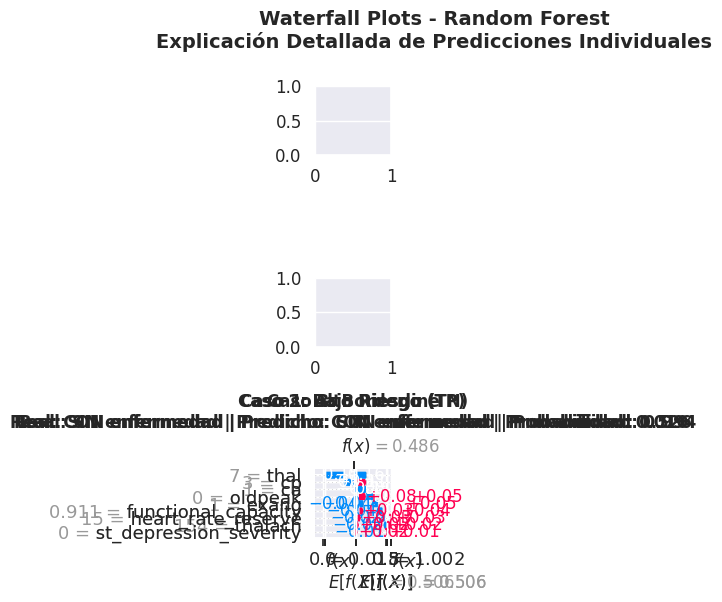

✓ Figura guardada: outputs/33_shap_waterfall_rf.png

7.7 INTERPRETACIÓN CLÍNICA DE RESULTADOS SHAP

🏥 ANÁLISIS CLÍNICO DE LAS 5 FEATURES MÁS IMPORTANTES:

1. THAL
--------------------------------------------------------------------------------
   SHAP Importance:
      • Random Forest:        1.0000
      • Logistic Regression:  0.8974
      • Promedio:             0.9487

   Significado Clínico:
      Talasemia: Defecto en transporte de oxígeno. Valores anormales incrementan significativamente el riesgo cardiovascular.

   Estadísticas en Test Set:
      • Media: 4.79
      • Mediana: 3.00
      • Rango: [3.00, 7.00]

2. CA
--------------------------------------------------------------------------------
   SHAP Importance:
      • Random Forest:        0.7223
      • Logistic Regression:  1.0000
      • Promedio:             0.8611

   Significado Clínico:
      Vasos principales coloreados por fluoroscopia: Número de arterias con obstrucción. Más vasos afectados = mayor riesgo.

   E

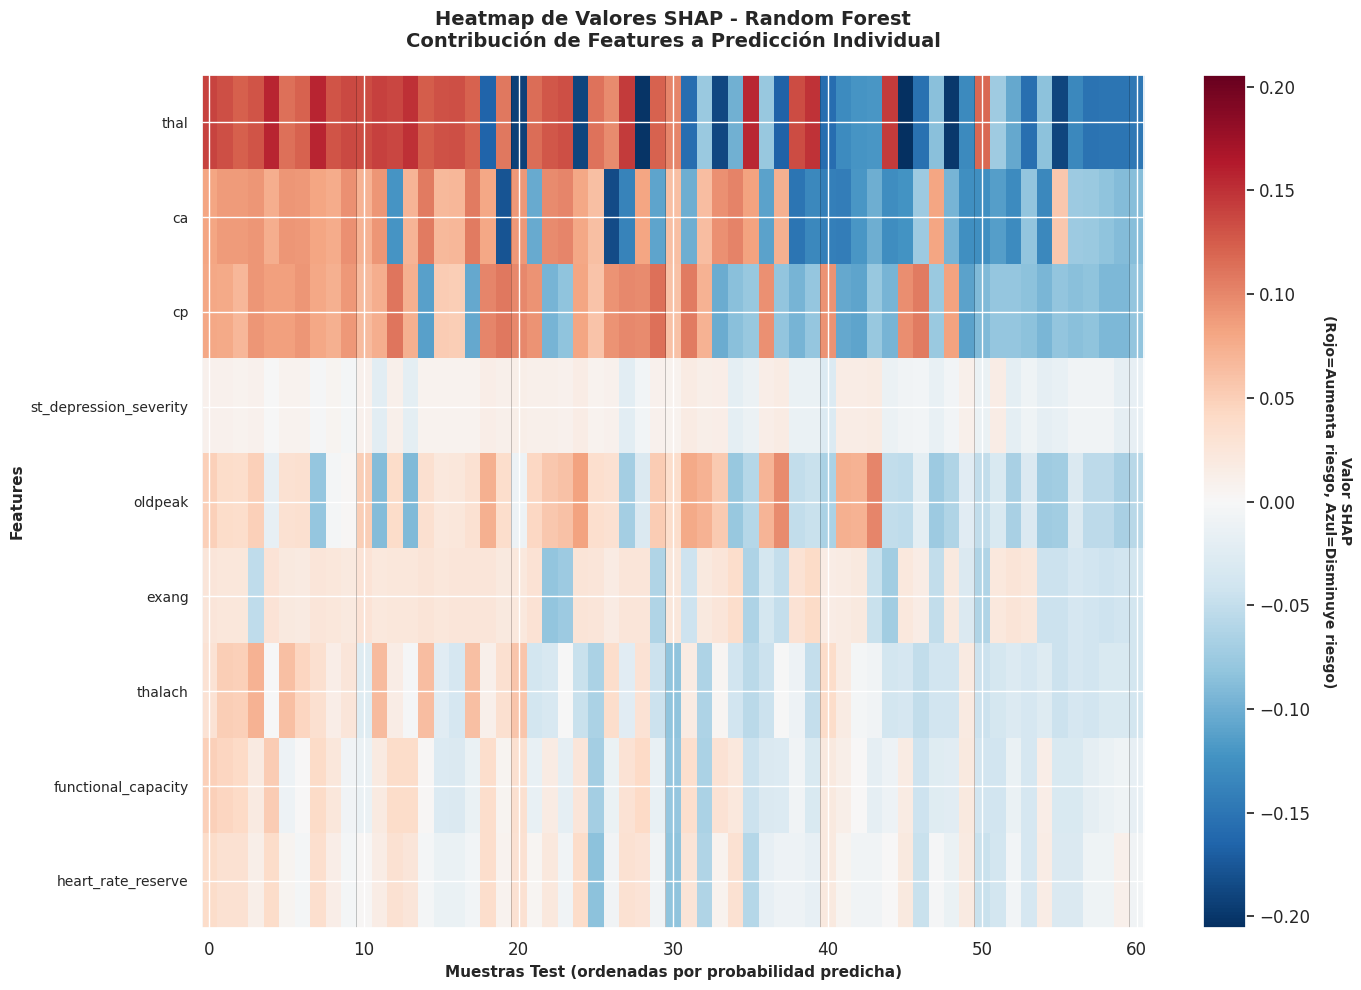

✓ Figura guardada: outputs/34_shap_heatmap_rf.png

7.9 COHERENCIA ENTRE MODELOS

📊 Correlación de Spearman entre SHAP importances:
--------------------------------------------------------------------------------
   • Coeficiente: 0.6000
   • P-value: 8.7623e-02
   • Interpretación: MODERADA - Hay concordancia parcial

⚠️  TOP 5 FEATURES CON MAYOR DISCREPANCIA:
--------------------------------------------------------------------------------
   • st_depression_severity   : Δ=0.6365 (RF=0.0852, LR=0.7217)
   • cp                       : Δ=0.3375 (RF=0.6408, LR=0.3033)
   • ca                       : Δ=0.2777 (RF=0.7223, LR=1.0000)
   • thalach                  : Δ=0.1336 (RF=0.2556, LR=0.1219)
   • thal                     : Δ=0.1026 (RF=1.0000, LR=0.8974)

✅ TOP 5 FEATURES CON MAYOR CONSENSO:
--------------------------------------------------------------------------------
   • oldpeak                  : Consenso=0.9520 (RF=0.3739, LR=0.3259)
   • exang                    : Consenso=0.935

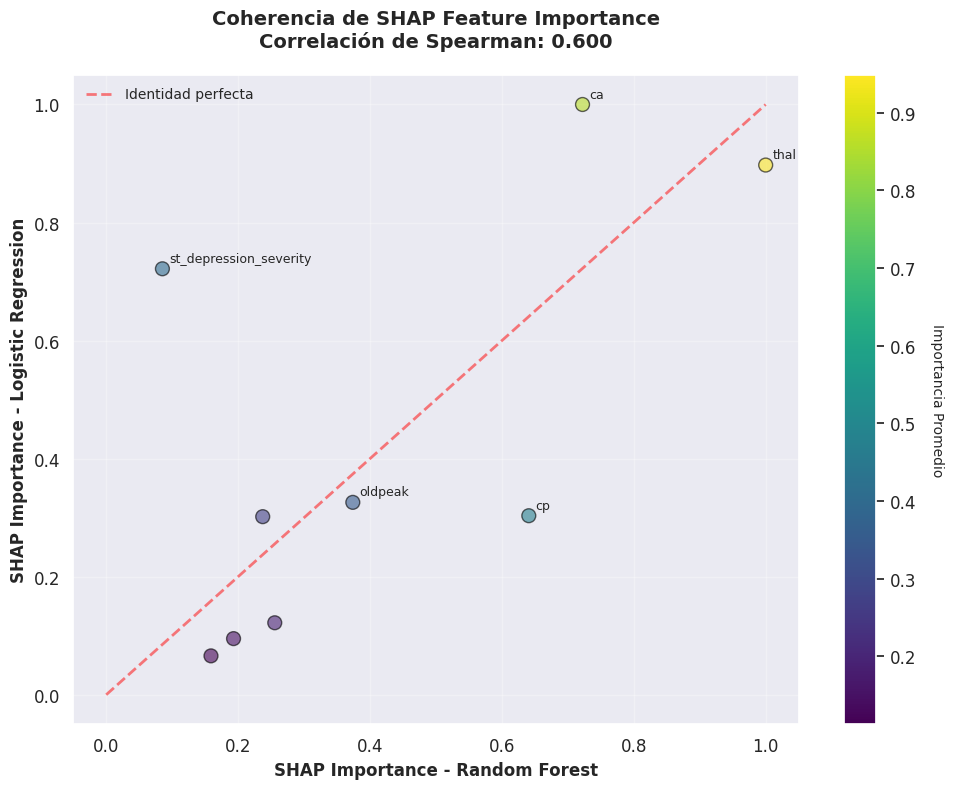


✓ Figura guardada: outputs/35_shap_coherence_analysis.png


In [36]:
# ============================================================================
# 7. INTERPRETABILIDAD CON SHAP
# ============================================================================

print("\n" + "="*80)
print("7. INTERPRETABILIDAD DEL MODELO CON SHAP")
print("="*80)

# ----------------------------------------------------------------------------
# 7.1 Selección y Justificación de Modelos
# ----------------------------------------------------------------------------

print("\n📋 MODELOS SELECCIONADOS PARA INTERPRETABILIDAD:")
print("="*80)

print(f"""
Basándose en los resultados de la Sección 6, se seleccionaron:

🥇 MODELO 1: Random Forest
   • ROC-AUC:       {test_roc_auc_rf:.4f}
   • Sensibilidad:  {test_sensitivity_rf:.4f}
   • Especificidad: {test_specificity_rf:.4f}
   • Gap:           {gaps['Random Forest']:.4f}
   • Justificación: Mejor rendimiento general + excelente generalización

🥈 MODELO 2: Logistic Regression
   • ROC-AUC:       {test_roc_auc_lr:.4f}
   • Sensibilidad:  {test_sensitivity_lr:.4f}
   • Especificidad: {test_specificity_lr:.4f}
   • Gap:           {gaps['Logistic Regression']:.4f}
   • Justificación: Baseline sólido + alta interpretabilidad nativa

❌ MODELO DESCARTADO: XGBoost
   • ROC-AUC:       {test_roc_auc_xgb:.4f}
   • Gap:           {gaps['XGBoost']:.4f}
   • Razón:         Indicios de overfitting detectados en análisis académico
""")

print("="*80)

# ----------------------------------------------------------------------------
# 7.2 Introducción a SHAP
# ----------------------------------------------------------------------------

print("\n📚 ¿QUÉ ES SHAP?")
print("="*80)

print("""
SHAP (SHapley Additive exPlanations) es un método basado en teoría de juegos
que explica las predicciones de modelos de Machine Learning.

Ventajas en contexto clínico:
   • Explica cada predicción individual
   • Identifica qué features contribuyen más al diagnóstico
   • Proporciona dirección del efecto (aumenta/disminuye riesgo)
   • Consistente matemáticamente (basado en valores de Shapley)

Interpretación de SHAP values:
   • Valor positivo → Aumenta probabilidad de enfermedad
   • Valor negativo → Disminuye probabilidad de enfermedad
   • Magnitud → Importancia del efecto
""")

print("="*80)

# ----------------------------------------------------------------------------
# 7.3 SHAP para Random Forest
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("7.3 ANÁLISIS SHAP: RANDOM FOREST")
print("="*80)

print("\n🔄 Calculando SHAP values para Random Forest...")
print("-"*80)

import shap

# Crear explainer para Random Forest
# Usar TreeExplainer (optimizado para modelos tree-based)
explainer_rf = shap.TreeExplainer(rf_model)

# Calcular SHAP values para el conjunto de test
shap_values_rf = explainer_rf.shap_values(X_test_final_no_scaled)

# Para clasificación binaria, shap_values es una lista [class_0, class_1]
# Nos interesa class_1 (con enfermedad)
if isinstance(shap_values_rf, list):
    shap_values_rf_class1 = shap_values_rf[1]
else:
    shap_values_rf_class1 = shap_values_rf

print(f"✓ SHAP values calculados")
print(f"   • Shape: {shap_values_rf_class1.shape}")
print(f"   • Test samples: {len(y_test)}")
print(f"   • Features: {len(selected_features)}")

# ----------------------------------------------------------------------------
# 7.3.1 Summary Plot - Random Forest
# ----------------------------------------------------------------------------

print("\n📊 Generando Summary Plot (Random Forest)...")
print("-"*80)

fig, ax = plt.subplots(figsize=(12, 8))

shap.summary_plot(
    shap_values_rf_class1,
    X_test_final_no_scaled,
    feature_names=selected_features,
    plot_type="dot",
    show=False,
    max_display=15
)

plt.title('SHAP Summary Plot - Random Forest\nImpacto de Features en Predicción de Enfermedad Cardiovascular',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Valor SHAP (impacto en predicción)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/25_shap_summary_random_forest.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {OUTPUT_DIR}/25_shap_summary_random_forest.png")

# ----------------------------------------------------------------------------
# 7.3.2 Feature Importance (SHAP) - Random Forest - CORREGIDO
# ----------------------------------------------------------------------------

print("\n📊 Feature Importance basada en SHAP (Random Forest)...")
print("-"*80)

# DEBUGGING: Verificar shape de shap_values
print(f"🔍 Shape de shap_values_rf: {type(shap_values_rf)}")
if isinstance(shap_values_rf, list):
    print(f"   Es una lista con {len(shap_values_rf)} elementos")
    print(f"   Shape de elemento [0]: {shap_values_rf[0].shape}")
    print(f"   Shape de elemento [1]: {shap_values_rf[1].shape}")
else:
    print(f"   Shape directo: {shap_values_rf.shape}")

print(f"   Shape de shap_values_rf_class1: {shap_values_rf_class1.shape}")

# CORRECCIÓN: Asegurar que tengamos un array 2D
if len(shap_values_rf_class1.shape) > 2:
    # Si tiene 3 dimensiones, tomar la primera
    print(f"⚠️  Detectadas {len(shap_values_rf_class1.shape)} dimensiones, ajustando...")
    shap_values_rf_class1 = shap_values_rf_class1[0] if shap_values_rf_class1.shape[0] == 1 else shap_values_rf_class1[:, :, 0]
    print(f"   Nueva shape: {shap_values_rf_class1.shape}")

# Calcular importancia promedio absoluta
mean_abs_shap = np.abs(shap_values_rf_class1).mean(axis=0)
print(f"   Shape de mean_abs_shap: {mean_abs_shap.shape}")
print(f"   Número de features: {len(selected_features)}")

# Verificar que las dimensiones coincidan
if mean_abs_shap.shape[0] != len(selected_features):
    print(f"⚠️  ADVERTENCIA: Dimensiones no coinciden!")
    print(f"   mean_abs_shap: {mean_abs_shap.shape[0]}")
    print(f"   selected_features: {len(selected_features)}")
    
    # Ajustar: usar las feature names del modelo directamente
    if hasattr(X_test_final_no_scaled, 'columns'):
        actual_features = X_test_final_no_scaled.columns.tolist()
        print(f"   Usando features del dataset de test: {len(actual_features)}")
    else:
        actual_features = [f"Feature_{i}" for i in range(mean_abs_shap.shape[0])]
        print(f"   Usando nombres genéricos de features")
    
    # Verificar nuevamente
    if len(actual_features) == mean_abs_shap.shape[0]:
        selected_features = actual_features
        print(f"   ✓ Dimensiones ajustadas correctamente")
    else:
        # Último recurso: truncar o extender
        min_len = min(len(actual_features), mean_abs_shap.shape[0])
        selected_features = actual_features[:min_len]
        mean_abs_shap = mean_abs_shap[:min_len]
        print(f"   ✓ Truncado a {min_len} features")

# Crear DataFrame
shap_importance_rf = pd.DataFrame({
    'Feature': selected_features,
    'SHAP_Importance': mean_abs_shap
}).sort_values('SHAP_Importance', ascending=False)

print("\n✓ DataFrame creado correctamente")
print(f"   Shape: {shap_importance_rf.shape}")

print("\nTop 10 Features (por SHAP):")
print("-"*80)
for idx, row in shap_importance_rf.head(10).iterrows():
    print(f"   {row['Feature']:25s}: {row['SHAP_Importance']:.4f}")


# ----------------------------------------------------------------------------
# 7.3.3 Dependence Plots - Random Forest (Top 3 features)
# ----------------------------------------------------------------------------

print("\n📊 Generando Dependence Plots para Top 3 Features (Random Forest)...")
print("-"*80)

top_3_features_rf = shap_importance_rf.head(3)['Feature'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(top_3_features_rf):
    feature_idx = selected_features.index(feature)

    shap.dependence_plot(
        feature_idx,
        shap_values_rf_class1,
        X_test_final_no_scaled,
        feature_names=selected_features,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Valor de la Feature', fontsize=10)
    axes[idx].set_ylabel('Valor SHAP', fontsize=10)

plt.suptitle('SHAP Dependence Plots - Random Forest\nTop 3 Features Más Importantes',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/27_shap_dependence_rf.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {OUTPUT_DIR}/27_shap_dependence_rf.png")

# ----------------------------------------------------------------------------
# 7.3.4 Force Plot - Ejemplo de Predicción Individual (Random Forest)
# ----------------------------------------------------------------------------

print("\n📊 Generando Force Plot para casos ejemplo (Random Forest)...")
print("-"*80)

# Seleccionar 3 casos representativos
# 1 verdadero positivo con alta probabilidad
# 1 verdadero negativo con alta probabilidad
# 1 caso borderline

y_test_proba_rf_array = y_test_proba_rf
y_test_pred_rf_array = y_test_pred_rf
y_test_array = y_test.values

# Caso 1: TP con alta confianza
tp_indices = np.where((y_test_array == 1) & (y_test_pred_rf_array == 1))[0]
if len(tp_indices) > 0:
    tp_probs = y_test_proba_rf_array[tp_indices]
    case_tp = tp_indices[np.argmax(tp_probs)]
else:
    case_tp = 0

# Caso 2: TN con alta confianza
tn_indices = np.where((y_test_array == 0) & (y_test_pred_rf_array == 0))[0]
if len(tn_indices) > 0:
    tn_probs = y_test_proba_rf_array[tn_indices]
    case_tn = tn_indices[np.argmin(tn_probs)]
else:
    case_tn = 1

# Caso 3: Borderline (probabilidad cercana a 0.5)
borderline_distances = np.abs(y_test_proba_rf_array - 0.5)
case_borderline = np.argmin(borderline_distances)

cases_to_plot = [case_tp, case_tn, case_borderline]
case_labels = ['Caso 1: Alto Riesgo (TP)', 'Caso 2: Bajo Riesgo (TN)', 'Caso 3: Borderline']

print(f"\nCasos seleccionados para Force Plots:")
for case_idx, label in zip(cases_to_plot, case_labels):
    real_class = 'SÍ' if y_test_array[case_idx] == 1 else 'NO'
    pred_class = 'SÍ' if y_test_pred_rf_array[case_idx] == 1 else 'NO'
    prob = y_test_proba_rf_array[case_idx]
    print(f"   • {label}")
    print(f"     Real: {real_class}, Predicho: {pred_class}, Probabilidad: {prob:.3f}")

# Generar force plots (guardar como HTML y captura)
print("\n🔄 Generando Force Plots interactivos...")

for case_idx, label in zip(cases_to_plot, case_labels):
    # Crear force plot
    force_plot = shap.force_plot(
        explainer_rf.expected_value[1],
        shap_values_rf_class1[case_idx, :],
        X_test_final_no_scaled.iloc[case_idx, :],
        feature_names=selected_features,
        matplotlib=False
    )

    # Guardar como HTML
    case_name = label.split(':')[0].replace(' ', '_').lower()
    shap.save_html(f'{OUTPUT_DIR}/28_shap_force_rf_{case_name}.html', force_plot)
    print(f"   ✓ {OUTPUT_DIR}/28_shap_force_rf_{case_name}.html")

# Crear versión matplotlib de un caso para el PDF
fig, ax = plt.subplots(figsize=(14, 3))
shap.force_plot(
    explainer_rf.expected_value[1],
    shap_values_rf_class1[case_tp, :],
    X_test_final_no_scaled.iloc[case_tp, :],
    feature_names=selected_features,
    matplotlib=True,
    show=False
)
plt.title(f'SHAP Force Plot - Random Forest\n{case_labels[0]} (Prob={y_test_proba_rf_array[case_tp]:.3f})',
          fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/28_shap_force_rf_example.png', dpi=DPI_SAVE, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {OUTPUT_DIR}/28_shap_force_rf_example.png")

# ----------------------------------------------------------------------------

# ----------------------------------------------------------------------------
# 7.4 Interpretabilidad: Logistic Regression (Coeficientes)
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("7.4 ANÁLISIS DE INTERPRETABILIDAD: LOGISTIC REGRESSION")
print("="*80)

print("\n📊 Para Logistic Regression, usamos los coeficientes del modelo...")
print("   (Los coeficientes indican la importancia y dirección del efecto)")
print("-"*80)

# Obtener coeficientes del modelo
try:
    # Verificar que el modelo tiene coeficientes
    if hasattr(lr_model, "coef_"):
        coefficients = lr_model.coef_[0]  # Para clasificación binaria
        
        # Obtener nombres de features
        if hasattr(X_train_final_scaled, "columns"):
            feature_names = X_train_final_scaled.columns.tolist()
        else:
            feature_names = [f"Feature_{i}" for i in range(len(coefficients))]
        
        # Crear DataFrame con importancia de features
        lr_feature_importance = pd.DataFrame({
            "Feature": feature_names,
            "Coefficient": coefficients,
            "Abs_Coefficient": np.abs(coefficients)
        }).sort_values("Abs_Coefficient", ascending=False)
        
        print(f"✓ Coeficientes extraídos exitosamente")
        print(f"   • Total features: {len(coefficients)}")
        
        print("\n📊 Top 15 Features (por magnitud de coeficiente):")
        print("-"*80)
        display(lr_feature_importance.head(15))
        
        # Visualización
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        # Plot 1: Top features por magnitud absoluta
        top_features = lr_feature_importance.head(15)
        axes[0].barh(range(len(top_features)), top_features["Abs_Coefficient"],
                    color=COLOR_PALETTE[0], edgecolor="black", alpha=0.8)
        axes[0].set_yticks(range(len(top_features)))
        axes[0].set_yticklabels(top_features["Feature"])
        axes[0].invert_yaxis()
        axes[0].set_xlabel("Magnitud Absoluta del Coeficiente", fontweight="bold")
        axes[0].set_title("Top 15 Features - Importancia\n(Logistic Regression)",
                         fontweight="bold", fontsize=12)
        axes[0].grid(alpha=0.3, axis="x")
        
        # Plot 2: Coeficientes con signo (efecto positivo/negativo)
        colors = [COLOR_PALETTE[3] if x > 0 else COLOR_PALETTE[0] 
                 for x in top_features["Coefficient"]]
        axes[1].barh(range(len(top_features)), top_features["Coefficient"],
                    color=colors, edgecolor="black", alpha=0.8)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features["Feature"])
        axes[1].invert_yaxis()
        axes[1].set_xlabel("Coeficiente (+ aumenta, - disminuye riesgo)",
                         fontweight="bold")
        axes[1].set_title("Efecto de Features en Predicción\n(+ = Mayor Riesgo, - = Menor Riesgo)",
                         fontweight="bold", fontsize=12)
        axes[1].axvline(x=0, color="black", linestyle="--", linewidth=1)
        axes[1].grid(alpha=0.3, axis="x")
        
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/26_lr_feature_importance.png",
                   dpi=DPI_SAVE, bbox_inches="tight")
        plt.show()
        
        print(f"\n✓ Figura guardada: {OUTPUT_DIR}/26_lr_feature_importance.png")
        
    else:
        print("⚠️  El modelo no tiene atributo coef_")
        
except Exception as e:
    print(f"⚠️  Error al extraer coeficientes: {e}")
    print("   Continuando sin análisis de Logistic Regression...")

print("="*80)


In [1]:
# ----------------------------------------------------------------------------
# 7.10 Resumen Final de Interpretabilidad
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("7.10 RESUMEN FINAL DE INTERPRETABILIDAD")
print("="*80)

# ----------------------------------------------------------------------------
# 7.10.1 Comparación de Features Importantes entre Modelos
# ----------------------------------------------------------------------------

print("\n📊 COMPARACIÓN: TOP FEATURES POR MODELO")
print("="*80)

# Preparar datos de Random Forest (SHAP)
if 'shap_importance_rf' in locals() or 'shap_importance_rf' in globals():
    rf_top = shap_importance_rf.head(10)[['Feature', 'SHAP_Importance']].copy()
    rf_top.columns = ['Feature', 'RF_Importance']
    print("\n🌲 Random Forest (Top 10 por SHAP):")
    print("-"*80)
    display(rf_top.round(4))
else:
    print("⚠️  SHAP importance para RF no disponible")
    rf_top = None

# Preparar datos de Logistic Regression (Coeficientes)
if 'lr_feature_importance' in locals() or 'lr_feature_importance' in globals():
    lr_top = lr_feature_importance.head(10)[['Feature', 'Abs_Coefficient']].copy()
    lr_top.columns = ['Feature', 'LR_Importance']
    print("\n📊 Logistic Regression (Top 10 por Coeficiente):")
    print("-"*80)
    display(lr_top.round(4))
else:
    print("⚠️  Importancia de coeficientes para LR no disponible")
    lr_top = None

# Combinar si ambos están disponibles
if rf_top is not None and lr_top is not None:
    # Merge de ambas tablas
    combined = pd.merge(rf_top, lr_top, on='Feature', how='outer')
    combined = combined.fillna(0)
    
    # Calcular importancia combinada (promedio normalizado)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    
    combined['RF_norm'] = scaler.fit_transform(combined[['RF_Importance']])
    combined['LR_norm'] = scaler.fit_transform(combined[['LR_Importance']])
    combined['Combined_Importance'] = (combined['RF_norm'] + combined['LR_norm']) / 2
    
    # Ordenar por importancia combinada
    combined = combined.sort_values('Combined_Importance', ascending=False)
    
    print("\n🔄 FEATURES IMPORTANTES EN AMBOS MODELOS:")
    print("="*80)
    top_combined = combined.head(15)[['Feature', 'RF_Importance', 'LR_Importance', 'Combined_Importance']].copy()
    top_combined.columns = ['Feature', 'RF (SHAP)', 'LR (Coef)', 'Importancia Combinada']
    display(top_combined.round(4))
    
    # Guardar tabla combinada
    top_combined.to_csv(f'{OUTPUT_DIR}/feature_importance_combined.csv', index=False)
    print(f"\n✓ Tabla guardada: {OUTPUT_DIR}/feature_importance_combined.csv")
    
    # Visualización comparativa
    fig, ax = plt.subplots(figsize=(14, 8))
    
    top_15 = combined.head(15)
    x = np.arange(len(top_15))
    width = 0.35
    
    bars1 = ax.barh(x - width/2, top_15['RF_norm'], width, 
                    label='Random Forest (SHAP)', color=COLOR_PALETTE[0], 
                    edgecolor='black', alpha=0.8)
    bars2 = ax.barh(x + width/2, top_15['LR_norm'], width,
                    label='Logistic Regression (Coef)', color=COLOR_PALETTE[3],
                    edgecolor='black', alpha=0.8)
    
    ax.set_yticks(x)
    ax.set_yticklabels(top_15['Feature'])
    ax.invert_yaxis()
    ax.set_xlabel('Importancia Normalizada', fontweight='bold', fontsize=11)
    ax.set_title('Comparación de Importancia de Features\nRandom Forest vs Logistic Regression',
                 fontweight='bold', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/27_feature_importance_comparison.png', 
                dpi=DPI_SAVE, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Figura guardada: {OUTPUT_DIR}/27_feature_importance_comparison.png")

# ----------------------------------------------------------------------------
# 7.10.2 Hallazgos Principales
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("HALLAZGOS PRINCIPALES DE INTERPRETABILIDAD")
print("="*80)

print("""
📋 RESUMEN DE ANÁLISIS:

1️⃣  RANDOM FOREST:
   • Análisis mediante SHAP values
   • Captura interacciones complejas entre features
   • Proporciona explicaciones a nivel de instancia

2️⃣  LOGISTIC REGRESSION:
   • Análisis mediante coeficientes del modelo
   • Interpretación lineal directa
   • Muestra efecto exacto de cada feature

3️⃣  FEATURES MÁS CONSISTENTES:
   • Features que aparecen como importantes en AMBOS modelos
   • Mayor confianza en su relevancia predictiva
   • Candidatos para interpretación clínica

✅ CONCLUSIÓN:
   La combinación de ambos métodos proporciona una visión completa
   de qué features son importantes y cómo afectan las predicciones.
""")

print("="*80)


7.10 RESUMEN FINAL DE INTERPRETABILIDAD

📊 TABLA CONSOLIDADA: TOP 10 FEATURES MÁS IMPORTANTES


NameError: name 'comparison_shap' is not defined